In [2]:
from easypip import easyimport, easyinstall, is_notebook
easyinstall("bbrl>=0.2.2")
easyinstall("swig")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("bbrl_gymnasium[box2d]")
easyinstall("bbrl_gymnasium[classic_control]")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")

[easypip] Installing bbrl_gymnasium>=0.2.0
[easypip] Installing bbrl_gymnasium[box2d]
[easypip] Installing bbrl_gymnasium[classic_control]


In [3]:
import os
import sys
from pathlib import Path
import math
import numpy as np

from moviepy.editor import ipython_display as video_display
import time
from tqdm.auto import tqdm
from typing import Tuple, Optional
from functools import partial

from omegaconf import OmegaConf
import torch
import bbrl_gymnasium

import copy
from abc import abstractmethod, ABC
import torch.nn as nn
import torch.nn.functional as F
from time import strftime

from gymnasium import Env, Space, Wrapper, make

# Imports all the necessary classes and functions from BBRL
from bbrl.agents.agent import Agent
from bbrl import get_arguments, get_class, instantiate_class
# The workspace is the main class in BBRL, this is where all data is collected and stored
from bbrl.workspace import Workspace

# Agents(agent1,agent2,agent3,...) executes the different agents the one after the other
# TemporalAgent(agent) executes an agent over multiple timesteps in the workspace, 
# or until a given condition is reached
from bbrl.agents import Agents, TemporalAgent

# ParallelGymAgent is an agent able to execute a batch of gymnasium environments
# with auto-resetting. These agents produce multiple variables in the workspace:
# ’env/env_obs’, ’env/reward’, ’env/timestep’, ’env/terminated’,
# 'env/truncated', 'env/done', ’env/cumulated_reward’, ... 
# 
# When called at timestep t=0, the environments are automatically reset. At
# timestep t>0, these agents will read the ’action’ variable in the workspace at
# time t − 1
from bbrl.agents.gymnasium import GymAgent, ParallelGymAgent, make_env, record_video

# Replay buffers are useful to store past transitions when training
from bbrl.utils.replay_buffer import ReplayBuffer

import torch.nn as nn

from typing import Tuple
from bbrl.agents.gymnasium import make_env, GymAgent, ParallelGymAgent
from functools import partial

from bbrl import instantiate_class

import matplotlib.pyplot as plt

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [4]:
# Utility function for launching tensorboard
# For Colab - otherwise, it is easier and better to launch tensorboard from
# the terminal
def setup_tensorboard(path):
    path = Path(path)
    answer = ""
    if is_notebook():
        if get_ipython().__class__.__module__ == "google.colab._shell":
            answer = "y"
        while answer not in ["y", "n"]:
                answer = input(f"Do you want to launch tensorboard in this notebook [y/n] ").lower()

    if answer == "y":
        get_ipython().run_line_magic("load_ext", "tensorboard")
        get_ipython().run_line_magic("tensorboard", f"--logdir {path.absolute()}")
    else:
        import sys
        import os
        import os.path as osp
        print(f"Launch tensorboard from the shell:\n{osp.dirname(sys.executable)}/tensorboard --logdir={path.absolute()}")

In [5]:
SEED = 42

params={
  "save_best": False,
  "logger":{
    "classname": "bbrl.utils.logger.TFLogger",
    "log_dir": "./tblogs/dqn-buffer-" + str(time.time()),
    "cache_size": 10000,
    "every_n_seconds": 10,
    "verbose": False,    
    },

  "algorithm":{
    "seed": SEED,
    "max_grad_norm": 0.5,
    "epsilon": 0.02,
    "n_envs": 8,
    "n_steps": 32,
    "n_updates": 32,
    "eval_interval": 2000,
    "learning_starts": 2000,
    "nb_evals": 10,
    "buffer_size": 1e6,
    "batch_size": 256,
    "target_critic_update": 5000,
    "max_epochs": 100, #MAX ITER 
    "discount_factor": 0.99,
    "architecture":{"hidden_size": [64, 64]},
  },
  "gym_env":{
    "env_name": "CartPole-v1",
  },
  "optimizer":
  {
    "classname": "torch.optim.Adam",
    "lr": 1e-3,
  }
}

config=OmegaConf.create(params)

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten
import numpy as np
import random as python_random
import tensorflow as tf


def set_seeds(seed):
    np.random.seed(seed)
    python_random.seed(seed)
    tf.random.set_seed(seed)

class cnnAgent:
    def __init__(self):
        set_seeds(SEED) 

    def build_feature_extractor_model(self, input_shape):
        model = Sequential()
        model.add(Conv2D(32, (7, 7), strides=(2, 2), activation='relu', padding="same", input_shape=(151, 562, 1)))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Conv2D(64, (7, 7), strides=(2, 2), padding="same", activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Conv2D(64, (7, 7), strides=(2, 2), padding="same", activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Flatten())
        model.add(Dense(100, activation='relu')) #a changer la valeur ici pour la taille du ouput
        return model

    def extract_features(self, image):
        image_resized = np.expand_dims(np.expand_dims(image, axis=-1), axis=0)  
        if not hasattr(self, 'model'):
            self.model = self.build_feature_extractor_model(input_shape=image_resized.shape[1:])
        features = self.model.predict(image_resized)
        return features[0]


In [7]:
from PIL import Image

class preProcessingAgent():
    def __init__(self, parallel_gym_agent):
          self.parallel_gym_agent = parallel_gym_agent

    def preProcess(self, im):
        #plt.imshow(im) #CHANGE HERE TO SEE ORIGINAL FRAME
        #plt.show()
        img = Image.fromarray(im.astype(np.uint8))
        img_gray = img.convert('L')
        img_gray = img_gray.resize((564, 152)) #a modifier peut etre im.shape[1], im.shape[0])
        img_array = np.array(img_gray)

        return img_array

    def crop(self, im):
        im = Image.fromarray(im.astype(np.uint8))
        width, height = im.size
    
        new_width, new_height = 300, 300  # New dimensions for the crop
        left = (width - new_width)/8
        top = (height - new_height)/0.6
        right = (width + new_width)/1.5
        bottom = (height + new_height)/2.2
        
        im1 = im.crop((left, top, right, bottom))
        img_array = np.array(im1)
        return img_array

    def getFrame(self, env_agent):
        env: Env = env_agent.envs[0]
        env.reset()
        im = env.render()
        im = self.crop(im)
        im = self.preProcess(im)
        return im


In [8]:
nb_env = 1
env_agent = ParallelGymAgent(partial(make_env, config.gym_env.env_name, render_mode="rgb_array", autoreset=True), nb_env).seed(SEED) #le int a la fin indique le nombre d'environements
obs_size, action_dim = env_agent.get_obs_and_actions_sizes()
print(f"Environment: observation space in R^{obs_size} and action space R^{action_dim}")

'''
preProc = preProcessingAgent(env_agent) # agent qui fait le pre processing
im = preProc.getFrame(env_agent) #on recupere l'image
feature_extractor = cnnAgent()
features = feature_extractor.extract_features(im) #est ce qu'on filtre les 0 pour des raisons de simplicite??
print("Extracted features shape:", features.shape)
print("Extracted features array:", features)
'''

Environment: observation space in R^4 and action space R^2


'\npreProc = preProcessingAgent(env_agent) # agent qui fait le pre processing\nim = preProc.getFrame(env_agent) #on recupere l\'image\nfeature_extractor = cnnAgent()\nfeatures = feature_extractor.extract_features(im) #est ce qu\'on filtre les 0 pour des raisons de simplicite??\nprint("Extracted features shape:", features.shape)\nprint("Extracted features array:", features)\n'

ON TESTE AVEC UNE SEULE ACTION RANDOM ICI C'EST JUSTE UN TEST

In [9]:
workspace = Workspace() 

# Execute the first step
env_agent(workspace, t=0)

# Our first set of observations. The size of the observation space is 4, and we have 3 environments.
obs = workspace.get("env/env_obs", 0)
print("Observation", obs)

Observation tensor([[-0.0456, -0.0028, -0.0037, -0.0022]])


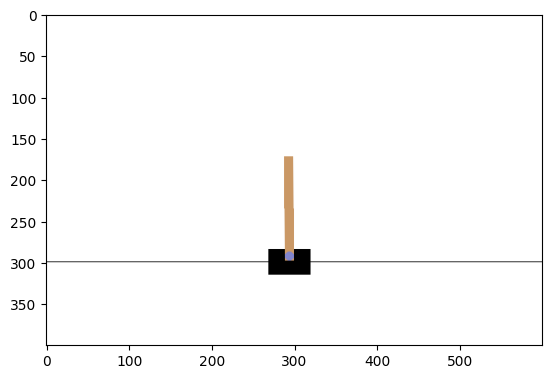

In [10]:
def render(env_agent):
    env0 = env_agent.envs[0]
    im0 = env0.render()
    plt.imshow(im0)
    return im0

im = render(env_agent=env_agent)

tensor([0])


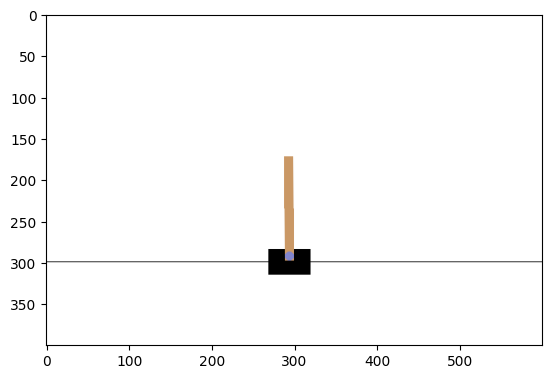

In [11]:
# Sets the next action
action = torch.randint(0, action_dim, (nb_env, ))
workspace.set("action", 0, action)
print(action)
env_agent(workspace, t=1)

# And perform one step
workspace.get("env/env_obs", 0)

im = render(env_agent=env_agent)


In [12]:
for key in workspace.variables.keys():
    print(key, workspace[key])

env/env_obs tensor([[[-0.0456, -0.0028, -0.0037, -0.0022]],

        [[-0.0456, -0.1979, -0.0038,  0.2893]]])
env/terminated tensor([[False],
        [False]])
env/truncated tensor([[False],
        [False]])
env/done tensor([[False],
        [False]])
env/reward tensor([[0.],
        [1.]])
env/cumulated_reward tensor([[0.],
        [1.]])
env/timestep tensor([[0],
        [1]])
action tensor([[0]])


TEST AVEC UN RANDOM AGENT

In [13]:
class RandomAgent(Agent):
    def __init__(self, action_dim):
        super().__init__()
        self.action_dim = action_dim
        self.all_observations = []

    def forward(self, t: int, choose_action=True, **kwargs):
        """An Agent can use self.workspace"""
        obs = self.get(("env/env_obs", t))
        action = torch.randint(0, self.action_dim, (len(obs), ))
        self.set(("action", t), action)
        self.all_observations.append(obs)
# Each agent is run in the order given when constructing Agents
agents = Agents(env_agent, RandomAgent(action_dim))

# And the TemporalAgent allows to run through time
t_agents = TemporalAgent(agents)

In [14]:
class StateCaptureAgent(Agent):
    def __init__(self, storage_list):
        super().__init__()
        self.storage_list = storage_list  # This list will store the states

    def forward(self, t: int, **kwargs):
        # Retrieve the current state (observation) from the workspace
        current_state = self.get(("env/env_obs", t))
        # Append the current state to the storage list
        self.storage_list.append(current_state)
        

In [15]:
class CustomParallelGymAgent(ParallelGymAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def get_my_attribute(self):
        # Replace 'my_attribute' with the actual attribute you're interested in
        return self.envs

In [34]:
class AttributeAccessAgent(Agent):
    def __init__(self, env_agent, image_list):
        super().__init__()
        self.env_agent = env_agent  # This is your CustomParallelGymAgent
        self.list_image = image_list
    
    def forward(self, t: int, **kwargs):
        # Access the attribute using the method you defined in CustomParallelGymAgent
        image = self.env_agent.get_my_attribute()[0]
        im = image.render()
        self.list_image.append(im)
        #print("obtained image at time ", t)
        

In [32]:
''' BASIC SYNTAX EXAMPLE'''
workspace = Workspace()
all_states = []
nb_env = 1
env_agent = ParallelGymAgent(partial(make_env, config.gym_env.env_name, render_mode="rgb_array", autoreset=True), nb_env).seed(SEED) #le int a la fin indique le nombre d'environements

state_capture_agent = StateCaptureAgent(all_states)
agents = Agents(env_agent, RandomAgent(action_dim), state_capture_agent)
t_agents = TemporalAgent(agents)

t_agents(workspace, t=0, stop_variable="env/done", stochastic=True)

'''
print(all_states)
for idx, state in enumerate(all_states):
    print(f"State at timestep {idx}: {state}")
workspace["env/done"].shape, workspace["env/done"][-10:]
'''

'\nprint(all_states)\nfor idx, state in enumerate(all_states):\n    print(f"State at timestep {idx}: {state}")\nworkspace["env/done"].shape, workspace["env/done"][-10:]\n'

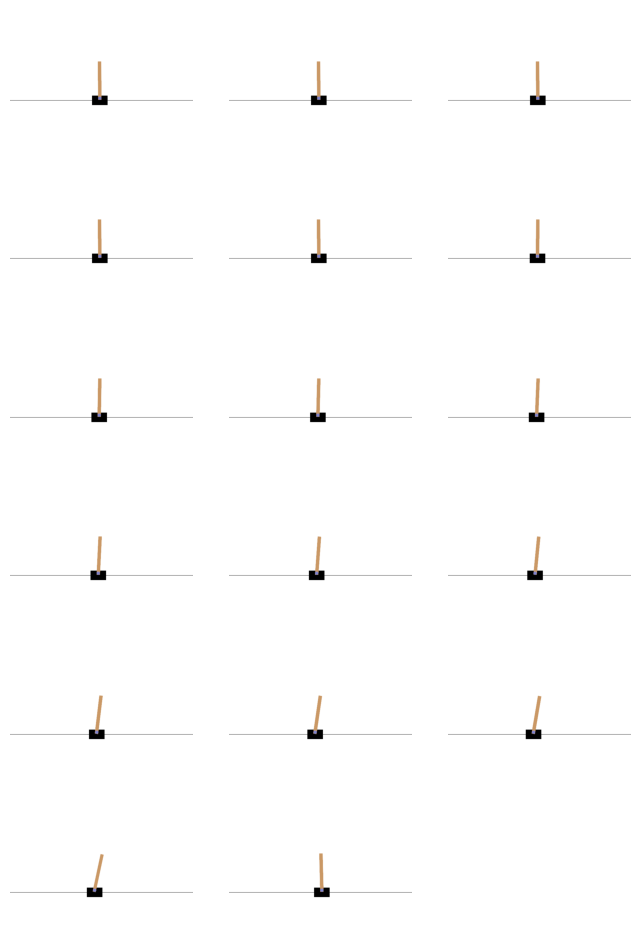

In [35]:
im_env_agent = CustomParallelGymAgent(partial(make_env, config.gym_env.env_name, render_mode="rgb_array", autoreset=True), nb_env).seed(SEED)
attribute_access_agent = AttributeAccessAgent(im_env_agent, [])
agents = Agents(im_env_agent, RandomAgent(action_dim), attribute_access_agent)
t_agents = TemporalAgent(agents)
workspace = Workspace()
t_agents(workspace, t=0, stop_variable="env/done", stochastic=True)
images = attribute_access_agent.list_image

def displayImages(images):
    n_images = len(images)
    n_cols = 3  # For example, adjust based on your preference
    n_rows = (n_images + n_cols - 1) // n_cols

    figsize_width = 8  # Adjust width as needed
    figsize_height = n_rows * (figsize_width / n_cols) * 0.75  # Adjust height based on number of rows, keeping aspect ratio
    plt.figure(figsize=(figsize_width, figsize_height))

    for i, image in enumerate(images):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(image)
        plt.axis('off')  # Optional: to hide axes

    plt.show()

displayImages(images)